In [1]:
import pandas as pd
import numpy as np
from math import *
from random import *
import datetime as datetime
import matplotlib.pyplot as plt
import math
from numpy import unravel_index
from PointProcess import PointProcessTrain
from PointProcess import PointProcessRun
from wasserstein import Cluster
from numpy import array

In [2]:
fields = ['XCOORD', 'YCOORD', 'CALL_TYPE_FINAL_D', 'CALL_TYPE_FINAL', 'DATE_TIME']
full_data = pd.read_csv('FixedLatLongTimeLoc_AndTimeSorted.csv', usecols=fields)
full_data['DATE_TIME'] =  pd.to_datetime(full_data['DATE_TIME'], format='%Y-%m-%d %H:%M:%S')
full_data = full_data.sort_values(by='DATE_TIME')
save_loc_out = 'Trained_Params_70_50_day3.npz'

In [3]:
end = len(full_data)- 90000
start = end-300000
data = full_data[start:end]
data.reset_index(drop=True, inplace=True)
#reasonable results
#all_events = PointProcessTrain(data, w = [.14, 1, .03],final_param_save_loc = save_loc, xgridsize = 70, ygridsize = 50) 
all_events = PointProcessTrain(data, w = [24, 4, 1],final_param_save_loc = save_loc_out, xgridsize = 70, ygridsize = 50, lam_memory=1000) 



In [4]:
all_events.train()

0.33333333333333337 percent trained
0.6666666666666667 percent trained
1.0 percent trained
1.3333333333333335 percent trained
1.6666666666666667 percent trained
2.0 percent trained
2.3333333333333335 percent trained
2.666666666666667 percent trained
3.0 percent trained
3.3333333333333335 percent trained
3.6666666666666665 percent trained
4.0 percent trained
4.333333333333334 percent trained
4.666666666666667 percent trained
5.0 percent trained
5.333333333333334 percent trained
5.666666666666666 percent trained
6.0 percent trained
6.333333333333334 percent trained
6.666666666666667 percent trained
7.000000000000001 percent trained
7.333333333333333 percent trained
7.666666666666666 percent trained
8.0 percent trained
8.333333333333332 percent trained
8.666666666666668 percent trained
9.0 percent trained
9.333333333333334 percent trained
9.666666666666666 percent trained
10.0 percent trained
10.333333333333334 percent trained
10.666666666666668 percent trained
11.0 percent trained
11.333

90.33333333333333 percent trained
90.66666666666666 percent trained
91.0 percent trained
91.33333333333333 percent trained
91.66666666666666 percent trained
92.0 percent trained
92.33333333333333 percent trained
92.66666666666666 percent trained
93.0 percent trained
93.33333333333333 percent trained
93.66666666666667 percent trained
94.0 percent trained
94.33333333333334 percent trained
94.66666666666667 percent trained
95.0 percent trained
95.33333333333334 percent trained
95.66666666666667 percent trained
96.0 percent trained
96.33333333333334 percent trained
96.66666666666667 percent trained
97.0 percent trained
97.33333333333334 percent trained
97.66666666666667 percent trained
98.0 percent trained
98.33333333333333 percent trained
98.66666666666667 percent trained
99.0 percent trained
99.33333333333333 percent trained
99.66666666666667 percent trained


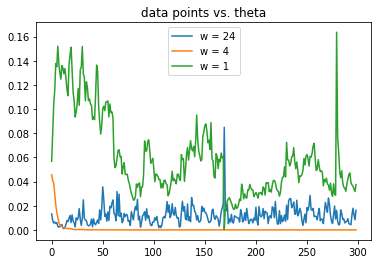


Sum of background rates w/o negative values: 283.9598523465486


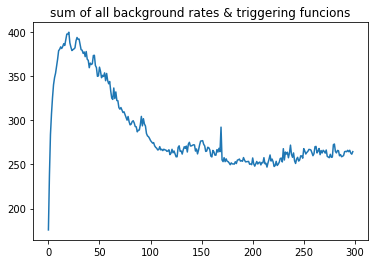

Hour vector sum: 
0.999999999999999


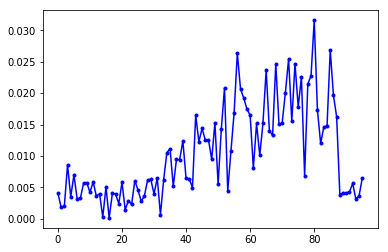

Day vector sum: 
1.00000000000832


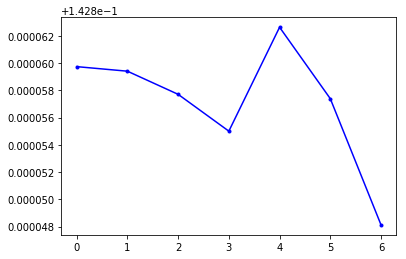

In [5]:
all_events.param_examine()

In [6]:
all_events.model_hotspot_examine(1000)

Location and value of largest and smallest sum(Lambda): 
55.12687236883562 (27, 23) -19.52907293087354 (16, 2)

Location and value of largest and smallest (final) background rate: 
2.7978862575404824 (27, 23) -1.067864841104125 (16, 2)

Location and value of largest and smallest (final) triggering function sum: 
0.23346964028679418 (25, 24, 0) -5.695805975087363e-17 (28, 23, 1)

Location and value of largest and smallest (final) intensities: 
0.04727967840818604 (27, 23) -0.017324279600405633 (16, 2)

Location of grid with most events:
16.0 (27, 23)

Historical time period is 3.4761188976 days

Trained hotspots in real top 10
Grid: (27, 23), Model: 18.396202982342423, Real: 16
Grid: (28, 23), Model: 14.336668410946192, Real: 15
Grid: (27, 24), Model: 14.26073667252939, Real: 8
Grid: (27, 22), Model: 13.292907141888357, Real: 8
Grid: (28, 24), Model: 8.950174973902651, Real: 11
Grid: (26, 23), Model: 8.192334759558051, Real: 7
Grid: (37, 23), Model: 8.13216165754789, Real: 8

Trained ho

#### Testing Projections w/Simulation

In [7]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

test_points = full_data[end:end+1000]
test_points.reset_index(drop=True,inplace=True)
ints,ig,pred,ig,ig,ig,ig,=simulation.test_projection(test_points, num_hotspots = 10, num_simulation_iters = 100)


Predicting over time of 3.5101814739 days. Generating 337 intensity prediction(s)
Events will be projected until 3.5104166666666665 days from now


ValueError: lam < 0

In [9]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

test_points = full_data[end:end+1000]
test_points.reset_index(drop=True,inplace=True)
ints,ig,pred,ig,ig,ig,ig,=simulation.test_projection(test_points, num_hotspots = 10, use_simulation=False)


Predicting over time of 3.5101814739 days. Generating 337 intensity prediction(s)

The predictive accuracy index for 10 hotspots is: 26.599999999999998. 
Hit number/Tot number: 0.076. Hit area/Tot area: 0.002857142857142857

The predicted number of events is: 817.9667565539835

Predicted hotspots in real top 10
Grid: (27, 23), Model: 9.154324909027094, Real: 7.0
Grid: (26, 22), Model: 7.4853447650111065, Real: 8.0
Grid: (28, 23), Model: 7.34292090215313, Real: 16.0
Grid: (27, 24), Model: 7.236527620934846, Real: 13.0
Grid: (27, 22), Model: 6.758741321889539, Real: 7.0
Grid: (34, 24), Model: 4.615499574488117, Real: 10.0

Predicted hotstpots not in real top 10
Grid: (27, 31), Model: 4.4703580713315665, Real: 5.0
Grid: (28, 24), Model: 4.419753693066294, Real: 3.0
Grid: (37, 23), Model: 4.073376932365114, Real: 3.0
Grid: (26, 23), Model: 4.044874142770402, Real: 4.0

Real top 10  hotspots not predicted
Grid: (33, 1), Model: 3.05885033763044, Real: 11.0
Grid: (47, 32), Model: 2.710611393

#### Lets get results

In [27]:
save_loc = 'Trained_Params_70_50.npz'

In [28]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')

In [29]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600: # 1 hour in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_1h = []
real_num_1h = []
pai_1h = []
for i in range(0, 60):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_simulation=False)
    pred_num_1h.append(sum(sum(pred)))
    real_num_1h.append(sum(sum(real)))
    pai_1h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.0364815632 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 6.140350877192982. 
Hit number/Tot number: 0.05263157894736842. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.90820501190071

Predicted hotspots in real top 30
Grid: (29, 22), Model: 0.0669847436908511, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15196377641140768, Real: 0.0
Grid: (27, 22), Model: 0.1511993229779424, Real: 0.0
Grid: (26, 22), Model: 0.1437179441769405, Real: 0.0
Grid: (27, 24), Model: 0.14285372584812273, Real: 0.0
Grid: (28, 23), Model: 0.10796727889925276, Real: 0.0
Grid: (8, 38), Model: 0.09896087804955955, Real: 0.0
Grid: (14, 22), Model: 0.09529829805638082, Real: 0.0
Grid: (11, 35), Model: 0.08382300645777982, Real: 0.0
Grid: (0, 31), Model: 0.08090506881317053, Real: 0.0
Grid: (26, 23), Model: 0.08086985395980958, Real: 0.0
Grid: (33, 25), Model: 0.08001496676654239, Re

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.0409028694 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 5.303030303030303. 
Hit number/Tot number: 0.045454545454545456. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.903201152810368

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.11103403800006395, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.11163294296027858, Real: 0.0
Grid: (27, 24), Model: 0.10511728861545508, Real: 0.0
Grid: (26, 22), Model: 0.10346681340043354, Real: 0.0
Grid: (28, 23), Model: 0.08006523027784034, Real: 0.0
Grid: (8, 38), Model: 0.07200267587641627, Real: 0.0
Grid: (14, 22), Model: 0.06943183010395193, Real: 0.0
Grid: (11, 35), Model: 0.0610741563072897, Real: 0.0
Grid: (0, 31), Model: 0.058948130209074405, Real: 0.0
Grid: (26, 23), Model: 0.05804824671502541, Real: 0.0
Grid: (33, 25), Model: 0.057148046199685214, Real: 0.0
Grid: (27, 31), Model: 0.055412656723306


Predicting over time of 0.0411922219 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 35.8974358974359. 
Hit number/Tot number: 0.3076923076923077. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 8.239330017900176

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.06140059322712309, Real: 1.0
Grid: (44, 32), Model: 0.03290843880729445, Real: 1.0
Grid: (36, 24), Model: 0.03164980585281221, Real: 1.0
Grid: (33, 24), Model: 0.031110545741341703, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.08572164243026992, Real: 0.0
Grid: (27, 23), Model: 0.08486059171490394, Real: 0.0
Grid: (27, 24), Model: 0.08005334949834855, Real: 0.0
Grid: (26, 22), Model: 0.07742749507844587, Real: 0.0
Grid: (8, 38), Model: 0.054207036539349635, Real: 0.0
Grid: (14, 22), Model: 0.05230968634086018, Real: 0.0
Grid: (11, 35), Model: 0.046014553746290515, Real: 0.0
Grid: (0, 31), Model: 0.04441276523953663


Predicting over time of 0.0408449989 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.666666666666666. 
Hit number/Tot number: 0.1. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 4.605571629517835

Predicted hotspots in real top 30
Grid: (27, 26), Model: 0.01972917684263382, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.04817319893417558, Real: 0.0
Grid: (27, 23), Model: 0.04777780254029608, Real: 0.0
Grid: (27, 24), Model: 0.04518394480458482, Real: 0.0
Grid: (26, 22), Model: 0.043771572573069725, Real: 0.0
Grid: (28, 23), Model: 0.03476356026392427, Real: 0.0
Grid: (8, 38), Model: 0.03031274488587057, Real: 0.0
Grid: (14, 22), Model: 0.02927550277258708, Real: 0.0
Grid: (11, 35), Model: 0.025753578152422518, Real: 0.0
Grid: (0, 31), Model: 0.024857087271128682, Real: 0.0
Grid: (26, 23), Model: 0.024033358655887516, Real: 0.0
Grid: (33, 25), Model: 0.02352361424132504, Real: 0.0



Predicting over time of 0.0376852696 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 2.0166920323492143

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.009928094071599811, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.021599073861091576, Real: 0.0
Grid: (27, 23), Model: 0.020650871027976494, Real: 0.0
Grid: (27, 24), Model: 0.019545363849169137, Real: 0.0
Grid: (26, 22), Model: 0.01897551380712923, Real: 0.0
Grid: (28, 23), Model: 0.015028056835205288, Real: 0.0
Grid: (8, 38), Model: 0.013281849229496654, Real: 0.0
Grid: (14, 22), Model: 0.012835573113755955, Real: 0.0
Grid: (11, 35), Model: 0.01129196865155682, Real: 0.0
Grid: (0, 31), Model: 0.010898892960679613, Real: 0.0
Grid: (26, 23), Model: 0.010449550783196666, Real: 0.0
Grid: (33, 25), Model: 0.010202850028080333, R


Predicting over time of 0.0369329531 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 2.114643348102986

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.02021422140997585, Real: 1.0
Grid: (26, 32), Model: 0.008228033315815505, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.02236527775644861, Real: 0.0
Grid: (27, 23), Model: 0.02155229412289631, Real: 0.0
Grid: (27, 24), Model: 0.020407267259635202, Real: 0.0
Grid: (28, 23), Model: 0.016110149924770237, Real: 0.0
Grid: (8, 38), Model: 0.013969395895679193, Real: 0.0
Grid: (14, 22), Model: 0.013504777462480744, Real: 0.0
Grid: (11, 35), Model: 0.011881109055519062, Real: 0.0
Grid: (0, 31), Model: 0.011467526493982675, Real: 0.0
Grid: (28, 24), Model: 0.011118789035254251, Real: 0.0
Grid: (33, 25), Model: 0.01102769773419226, Real: 


Predicting over time of 0.0397454594 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 4.232776817453772

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.0442364662751447, Real: 0.0
Grid: (27, 23), Model: 0.04290583994885503, Real: 0.0
Grid: (26, 22), Model: 0.0408964479709688, Real: 0.0
Grid: (27, 24), Model: 0.04064028790270967, Real: 0.0
Grid: (28, 23), Model: 0.031916724949640485, Real: 0.0
Grid: (8, 38), Model: 0.027994563787248565, Real: 0.0
Grid: (14, 22), Model: 0.02707135552316521, Real: 0.0
Grid: (11, 35), Model: 0.023817443496615943, Real: 0.0
Grid: (0, 31), Model: 0.02298835852214734, Real: 0.0
Grid: (33, 25), Model: 0.021844004795663678, Real: 0.0
Grid: (26, 23), Model: 0.02183169792875987, Real: 0.0
Grid: (28, 24), Model: 0.0217372178655802, Real: 0.0
Grid: (27, 31), Mo


Predicting over time of 0.0366551747 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 24.561403508771928. 
Hit number/Tot number: 0.21052631578947367. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 11.574119762488092

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.11022699779846917, Real: 1.0
Grid: (28, 23), Model: 0.08613723670705693, Real: 1.0
Grid: (29, 22), Model: 0.052506767260071835, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.11919643420247107, Real: 0.0
Grid: (27, 23), Model: 0.1162666268289479, Real: 0.0
Grid: (27, 24), Model: 0.1101592905703834, Real: 0.0
Grid: (8, 38), Model: 0.07632142660192223, Real: 0.0
Grid: (14, 22), Model: 0.07382330639373104, Real: 0.0
Grid: (11, 35), Model: 0.06495250494150219, Real: 0.0
Grid: (0, 31), Model: 0.06269151664996821, Real: 0.0
Grid: (26, 23), Model: 0.059279179298520154, Real: 0.0
Grid: (33, 25), Model: 0.0589340640613650


Predicting over time of 0.0406945356 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.503499187704303

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.10836025136830076, Real: 0.0
Grid: (27, 23), Model: 0.10446421995986888, Real: 0.0
Grid: (26, 22), Model: 0.10224548004508481, Real: 0.0
Grid: (27, 24), Model: 0.10089252207219285, Real: 0.0
Grid: (28, 23), Model: 0.08069507966983087, Real: 0.0
Grid: (8, 38), Model: 0.06892333723793921, Real: 0.0
Grid: (14, 22), Model: 0.06668072605144082, Real: 0.0
Grid: (11, 35), Model: 0.05867055049126733, Real: 0.0
Grid: (0, 31), Model: 0.05662824335874511, Real: 0.0
Grid: (26, 23), Model: 0.05334037168898675, Real: 0.0
Grid: (33, 25), Model: 0.05276909405407374, Real: 0.0
Grid: (27, 26), Model: 0.052208881278579006, Real: 0.0
Grid: (28, 24), M


Predicting over time of 0.041319536999999996 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 8.974358974358974. 
Hit number/Tot number: 0.07692307692307693. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 2.8699547132352907

Predicted hotspots in real top 30
Grid: (33, 25), Model: 0.014307185039217874, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.03087577349254201, Real: 0.0
Grid: (27, 22), Model: 0.02987973662254834, Real: 0.0
Grid: (26, 22), Model: 0.02749920387518727, Real: 0.0
Grid: (27, 24), Model: 0.02730953877932224, Real: 0.0
Grid: (28, 23), Model: 0.021688482035314587, Real: 0.0
Grid: (8, 38), Model: 0.018827243234491038, Real: 0.0
Grid: (14, 22), Model: 0.018217671332311405, Real: 0.0
Grid: (11, 35), Model: 0.016029924914397562, Real: 0.0
Grid: (0, 31), Model: 0.015471929368729476, Real: 0.0
Grid: (26, 23), Model: 0.015009186708994966, Real: 0.0
Grid: (27, 26), Model: 0.01


Predicting over time of 0.0411922219 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 2.5539167596037102

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.024189645765960464, Real: 2.0
Grid: (26, 23), Model: 0.01320698773453839, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.027795116896641693, Real: 0.0
Grid: (27, 23), Model: 0.026877327070481696, Real: 0.0
Grid: (27, 24), Model: 0.024130801410355486, Real: 0.0
Grid: (28, 23), Model: 0.019071166635518406, Real: 0.0
Grid: (8, 38), Model: 0.016748896412268628, Real: 0.0
Grid: (14, 22), Model: 0.01620854042503769, Real: 0.0
Grid: (11, 35), Model: 0.014262645483864269, Real: 0.0
Grid: (0, 31), Model: 0.013766170028355694, Real: 0.0
Grid: (33, 25), Model: 0.013638344951664189, Real: 0.0
Grid: (34, 24), Model: 0.012473414242553403, Rea


Predicting over time of 0.0378820293 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 8.974358974358974. 
Hit number/Tot number: 0.07692307692307693. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 2.5701708104847016

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.02738259045525205, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.026657856280666352, Real: 0.0
Grid: (26, 22), Model: 0.025108321050604378, Real: 0.0
Grid: (27, 24), Model: 0.02423514966735424, Real: 0.0
Grid: (28, 23), Model: 0.01907678411738955, Real: 0.0
Grid: (8, 38), Model: 0.016926760381531625, Real: 0.0
Grid: (14, 22), Model: 0.01638235361241041, Real: 0.0
Grid: (11, 35), Model: 0.01441626101524577, Real: 0.0
Grid: (0, 31), Model: 0.013914440346967271, Real: 0.0
Grid: (26, 23), Model: 0.013635761910749212, Real: 0.0
Grid: (33, 25), Model: 0.01346604451996931, Real: 0.0
Grid: (27, 31), Model: 0.012400148339


The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 4.251247778156206

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.04723873675648278, Real: 0.0
Grid: (27, 23), Model: 0.04352855620143209, Real: 0.0
Grid: (26, 22), Model: 0.041843477520931455, Real: 0.0
Grid: (27, 24), Model: 0.039809031737740544, Real: 0.0
Grid: (28, 23), Model: 0.031276655395806145, Real: 0.0
Grid: (8, 38), Model: 0.027896482851709346, Real: 0.0
Grid: (14, 22), Model: 0.027000626489039392, Real: 0.0
Grid: (11, 35), Model: 0.02376090202273893, Real: 0.0
Grid: (0, 31), Model: 0.022933802639923288, Real: 0.0
Grid: (26, 23), Model: 0.022256062725752715, Real: 0.0
Grid: (33, 25), Model: 0.021939199579727058, Real: 0.0
Grid: (27, 31), Model: 0.020402196674648057, Real: 0.0
Grid: (41, 16), Model: 0.020302536857140775, Real: 0.0
Grid: (34, 24), Model: 0.02007114548


Predicting over time of 0.037384343 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 20.58823529411765. 
Hit number/Tot number: 0.17647058823529413. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 9.754862863443655

Predicted hotspots in real top 30
Grid: (27, 31), Model: 0.04669397029810606, Real: 1.0
Grid: (32, 25), Model: 0.044175426745326055, Real: 1.0
Grid: (29, 20), Model: 0.040535960214593596, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.10832069165104952, Real: 0.0
Grid: (27, 23), Model: 0.09902035562785975, Real: 0.0
Grid: (26, 22), Model: 0.09471513905336838, Real: 0.0
Grid: (27, 24), Model: 0.09098940687509538, Real: 0.0
Grid: (28, 23), Model: 0.07138128141273051, Real: 0.0
Grid: (8, 38), Model: 0.0639474053562726, Real: 0.0
Grid: (14, 22), Model: 0.061896359718042374, Real: 0.0
Grid: (11, 35), Model: 0.05447118504393536, Real: 0.0
Grid: (0, 31), Model: 0.05257508840152334


Predicting over time of 0.0369676754 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.11111111111111. 
Hit number/Tot number: 0.09523809523809523. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.827237476640525

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.16113562023727282, Real: 1.0
Grid: (27, 24), Model: 0.1407065874290776, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.14916556633352018, Real: 0.0
Grid: (26, 22), Model: 0.14554873850633715, Real: 0.0
Grid: (28, 23), Model: 0.11095538168958484, Real: 0.0
Grid: (8, 38), Model: 0.09694451995400222, Real: 0.0
Grid: (14, 22), Model: 0.09383821783181977, Real: 0.0
Grid: (11, 35), Model: 0.08258362249376125, Real: 0.0
Grid: (0, 31), Model: 0.07970896266767256, Real: 0.0
Grid: (26, 23), Model: 0.07622176462238264, Real: 0.0
Grid: (33, 25), Model: 0.07493242277775503, Real: 0.0
Grid: (27, 31), Model: 0.0731054646926543, 


Predicting over time of 0.0397223112 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 29.166666666666664. 
Hit number/Tot number: 0.25. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 6.047720385277437

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.06044470624909233, Real: 1.0
Grid: (27, 24), Model: 0.05822993075578288, Real: 1.0
Grid: (28, 23), Model: 0.04481292631718449, Real: 1.0
Grid: (36, 24), Model: 0.024504745337467347, Real: 1.0
Grid: (26, 26), Model: 0.022687164566057294, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.06578533801802107, Real: 0.0
Grid: (26, 22), Model: 0.05853825810473584, Real: 0.0
Grid: (8, 38), Model: 0.03950419412652274, Real: 0.0
Grid: (14, 22), Model: 0.03823945577999202, Real: 0.0
Grid: (11, 35), Model: 0.03365417043582533, Real: 0.0
Grid: (0, 31), Model: 0.032482702909902496, Real: 0.0
Grid: (26, 23), Model: 0.03087929407921522, Real: 0.0



Predicting over time of 0.0350116525 days. Generating 4 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 7.875663124228565

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 22), Model: 0.08374997602805505, Real: 0.0
Grid: (27, 23), Model: 0.08279788007757112, Real: 0.0
Grid: (27, 24), Model: 0.07786561158470033, Real: 0.0
Grid: (26, 22), Model: 0.07655076035793011, Real: 0.0
Grid: (28, 23), Model: 0.05914785290682934, Real: 0.0
Grid: (8, 38), Model: 0.05133467588330189, Real: 0.0
Grid: (14, 22), Model: 0.04969253772713786, Real: 0.0
Grid: (11, 35), Model: 0.04373561184090915, Real: 0.0
Grid: (0, 31), Model: 0.04221322487338928, Real: 0.0
Grid: (33, 25), Model: 0.040620124689854285, Real: 0.0
Grid: (27, 31), Model: 0.039935627695522315, Real: 0.0
Grid: (26, 23), Model: 0.03987611703271753, Real: 0.0
Grid: (41, 16), M

In [30]:
#print(pred_num_1h, real_num_1h, pai_1h)
print(np.mean(pred_num_1h), np.mean(real_num_1h), np.mean(pai_1h), 
      np.median(pred_num_1h), np.median(real_num_1h), np.median(pai_1h))

7.496791606415613 14.466666666666667 13.926060384213118 6.341453147802454 15.0 11.666666666666666


In [13]:
pai_1h

[8.333333333333332,
 21.21212121212121,
 19.444444444444443,
 25.925925925925924,
 0.0,
 58.33333333333333,
 31.818181818181813,
 29.166666666666664,
 27.45098039215686,
 10.606060606060606,
 7.777777777777778,
 15.217391304347824,
 13.72549019607843,
 21.875,
 21.21212121212121,
 10.144927536231883,
 6.862745098039215,
 35.0,
 23.333333333333332,
 0.0,
 25.925925925925924,
 35.0,
 19.444444444444443,
 23.333333333333332,
 25.925925925925924,
 19.444444444444443,
 23.333333333333332,
 46.666666666666664,
 0.0,
 10.606060606060606,
 0.0,
 10.606060606060606,
 15.555555555555555,
 11.666666666666666,
 25.925925925925924,
 15.555555555555555,
 31.11111111111111,
 8.974358974358974,
 32.407407407407405,
 16.666666666666664,
 0.0,
 33.33333333333333,
 36.45833333333333,
 23.333333333333332,
 14.583333333333332,
 42.42424242424242,
 17.94871794871795,
 19.444444444444443,
 11.666666666666666,
 19.444444444444443,
 0.0,
 0.0,
 21.875,
 5.833333333333333,
 34.31372549019608,
 8.333333333333332

In [14]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

Timestamp('2016-01-13 21:59:56')

In [15]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*2: # 2 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_2h = []
real_num_2h = []
pai_2h = []
for i in range(0, 60):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_simulation=False)
    pred_num_2h.append(sum(sum(pred)))
    real_num_2h.append(sum(sum(real)))
    pai_2h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.0806367547 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot number: 0.16666666666666666. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 8.649131775002576

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.0798373691400836, Real: 1.0
Grid: (34, 24), Model: 0.048849013673083794, Real: 1.0
Grid: (34, 23), Model: 0.03073004122465694, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.09705077490501492, Real: 0.0
Grid: (26, 22), Model: 0.07919369330057054, Real: 0.0
Grid: (27, 24), Model: 0.07557649871238954, Real: 0.0
Grid: (27, 22), Model: 0.07144772891838257, Real: 0.0
Grid: (28, 24), Model: 0.04833891123957302, Real: 0.0
Grid: (27, 31), Model: 0.04720043350622995, Real: 0.0
Grid: (37, 23), Model: 0.04435790793271102, Real: 0.0
Grid: (26, 23), Model: 0.04298511540002134, Real: 0.0
Grid: (35, 32), Model: 0.041275363674371

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.0753705392 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.5. 
Hit number/Tot number: 0.15. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.267482731283167

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.18722797802875382, Real: 1.0
Grid: (33, 1), Model: 0.06217588332017918, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.15274975824109982, Real: 0.0
Grid: (28, 23), Model: 0.14789818847172634, Real: 0.0
Grid: (27, 24), Model: 0.14197823237603244, Real: 0.0
Grid: (27, 22), Model: 0.1323999322971991, Real: 0.0
Grid: (34, 24), Model: 0.09484985879200708, Real: 0.0
Grid: (28, 24), Model: 0.08818952451201958, Real: 0.0
Grid: (27, 31), Model: 0.08752686828640847, Real: 0.0
Grid: (37, 23), Model: 0.0839671563131247, Real: 0.0
Grid: (35, 32), Model: 0.08262596479663217, Real: 0.0
Grid: (26, 23), Model: 0.07950937620428455, Real: 0.0
Grid: (32, 25), M


Predicting over time of 0.0812038856 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.27906976744186. 
Hit number/Tot number: 0.13953488372093023. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.875804468330116

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.20745943623406643, Real: 2.0
Grid: (27, 24), Model: 0.15819788152165593, Real: 1.0
Grid: (33, 1), Model: 0.07665676684464214, Real: 1.0
Grid: (37, 24), Model: 0.06570516572446262, Real: 1.0
Grid: (7, 32), Model: 0.06488851531403086, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.17496324641321243, Real: 0.0
Grid: (26, 22), Model: 0.16285923601930058, Real: 0.0
Grid: (27, 22), Model: 0.14591948901689256, Real: 0.0
Grid: (34, 24), Model: 0.10158859629903792, Real: 0.0
Grid: (28, 24), Model: 0.09525473803412846, Real: 0.0
Grid: (27, 31), Model: 0.0952240809197688, Real: 0.0
Grid: (37, 23), Model: 0.08939891980526292,


The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.139278088083897

Predicted hotspots in real top 30
Grid: (51, 33), Model: 0.03898964826532477, Real: 1.0
Grid: (29, 22), Model: 0.03731907424033627, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.11778863663378739, Real: 0.0
Grid: (28, 23), Model: 0.09568155440003726, Real: 0.0
Grid: (27, 24), Model: 0.09255884782964621, Real: 0.0
Grid: (26, 22), Model: 0.0916384311267191, Real: 0.0
Grid: (27, 22), Model: 0.08212777647827244, Real: 0.0
Grid: (34, 24), Model: 0.05929662258130965, Real: 0.0
Grid: (27, 31), Model: 0.05381699715186947, Real: 0.0
Grid: (28, 24), Model: 0.05353851955052998, Real: 0.0
Grid: (37, 23), Model: 0.05008348908315549, Real: 0.0
Grid: (26, 23), Model: 0.04876042439775334, Real: 0.0
Grid: (35, 32), Model: 0.04806439115372456, Real: 0.0
Grid: (32, 25


Predicting over time of 0.0795950857 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.21212121212121. 
Hit number/Tot number: 0.18181818181818182. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 6.206261824289933

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.05614731576950147, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.07078639108409449, Real: 0.0
Grid: (28, 23), Model: 0.05748421800844215, Real: 0.0
Grid: (27, 24), Model: 0.0564589816003079, Real: 0.0
Grid: (27, 22), Model: 0.05039912784634626, Real: 0.0
Grid: (34, 24), Model: 0.03539218596740067, Real: 0.0
Grid: (27, 31), Model: 0.03361940599774365, Real: 0.0
Grid: (28, 24), Model: 0.03276170210659053, Real: 0.0
Grid: (37, 23), Model: 0.030537395791672372, Real: 0.0
Grid: (26, 23), Model: 0.030508571612994723, Real: 0.0
Grid: (35, 32), Model: 0.029505557149044414, Real: 0.0
Grid: (32, 25), Model: 0.02914816650199


Predicting over time of 0.0831483344 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 25.925925925925924. 
Hit number/Tot number: 0.2222222222222222. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.121087598416135

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.14735323230114877, Real: 1.0
Grid: (28, 23), Model: 0.14586089207664177, Real: 1.0
Grid: (32, 25), Model: 0.07661189750306426, Real: 1.0
Grid: (29, 22), Model: 0.061715096063698724, Real: 1.0
Grid: (37, 24), Model: 0.05994555926433799, Real: 1.0
Grid: (34, 23), Model: 0.05756717085028033, Real: 1.0
Grid: (35, 23), Model: 0.05723697642938619, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1808904555965824, Real: 0.0
Grid: (27, 24), Model: 0.14813426644573444, Real: 0.0
Grid: (27, 22), Model: 0.13507877410305458, Real: 0.0
Grid: (34, 24), Model: 0.09072468865823954, Real: 0.0
Grid: (27, 31), Model: 0.088320855084804


Predicting over time of 0.0821413877 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 24.305555555555557. 
Hit number/Tot number: 0.20833333333333334. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.107673691446411

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.08239538097263514, Real: 1.0
Grid: (26, 23), Model: 0.04847582156297247, Real: 1.0
Grid: (26, 26), Model: 0.04352682395739979, Real: 1.0
Grid: (7, 32), Model: 0.03954613684596089, Real: 1.0
Grid: (34, 23), Model: 0.03678955776893634, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.11160919428917888, Real: 0.0
Grid: (28, 23), Model: 0.09713006137783331, Real: 0.0
Grid: (26, 22), Model: 0.09202181865424759, Real: 0.0
Grid: (27, 24), Model: 0.09116942132899894, Real: 0.0
Grid: (34, 24), Model: 0.05775267458937986, Real: 0.0
Grid: (27, 31), Model: 0.05712199926416998, Real: 0.0
Grid: (28, 24), Model: 0.054840748535717

Grid: (26, 32), Model: 0.023515935871344085, Real: 0.0
Grid: (33, 1), Model: 0.023424964028099578, Real: 0.0
Grid: (26, 27), Model: 0.023324078205392715, Real: 0.0
Grid: (33, 24), Model: 0.02330946876113728, Real: 0.0
Grid: (37, 24), Model: 0.023055679426497753, Real: 0.0
Grid: (47, 32), Model: 0.022954921247682065, Real: 0.0
Grid: (32, 23), Model: 0.022675672087625522, Real: 0.0
Grid: (44, 32), Model: 0.022415442017886686, Real: 0.0

Real top 30  hotspots not predicted
Grid: (9, 27), Model: 0.0051815094281433445, Real: 1.0
Grid: (26, 29), Model: 0.02157492964831073, Real: 1.0
Grid: (27, 26), Model: 0.02030504252274082, Real: 1.0
Grid: (28, 26), Model: 0.013175019035883298, Real: 1.0
Grid: (28, 29), Model: 0.007294340835593784, Real: 1.0
Grid: (31, 25), Model: 0.008794545366679393, Real: 1.0
Grid: (31, 33), Model: 0.004539140730277963, Real: 1.0
Grid: (32, 31), Model: 0.017415129527434497, Real: 1.0
Grid: (33, 13), Model: 0.013496123475923407, Real: 1.0
Grid: (33, 26), Model: 0.0183333


Predicting over time of 0.0816552755 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.22873176448496

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.12904419722252353, Real: 2.0
Grid: (27, 22), Model: 0.11689611150978672, Real: 1.0
Grid: (33, 1), Model: 0.05928918324051473, Real: 1.0
Grid: (33, 25), Model: 0.058776448596895466, Real: 1.0
Grid: (7, 32), Model: 0.05480359661707077, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15484855562415092, Real: 0.0
Grid: (27, 24), Model: 0.13056757137196803, Real: 0.0
Grid: (26, 22), Model: 0.13028582328042473, Real: 0.0
Grid: (34, 24), Model: 0.07884033646845826, Real: 0.0
Grid: (27, 31), Model: 0.07799521032645407, Real: 0.0
Grid: (28, 24), Model: 0.07505506823909124, Real: 0.0
Grid: (26, 23), Model: 0.07006615009711735, Real: 0.0
Gri

Predicting over time of 0.0813196266 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.21212121212121. 
Hit number/Tot number: 0.18181818181818182. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 15.321337035375471

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.14089702203419216, Real: 1.0
Grid: (34, 24), Model: 0.08660244833945001, Real: 1.0
Grid: (37, 23), Model: 0.0726926162127756, Real: 1.0
Grid: (33, 1), Model: 0.06509556652351146, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1661244934752143, Real: 0.0
Grid: (26, 22), Model: 0.1409657118075438, Real: 0.0
Grid: (27, 24), Model: 0.13782617818976794, Real: 0.0
Grid: (27, 22), Model: 0.12660141522231277, Real: 0.0
Grid: (27, 31), Model: 0.08313647685419433, Real: 0.0
Grid: (28, 24), Model: 0.08012603197263761, Real: 0.0
Grid: (26, 23), Model: 0.07471837599334857, Real: 0.0
Grid: (35, 32), Model: 0.07108956249272365, R


Predicting over time of 0.0720371984 days. Generating 7 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 0.0. 
Hit number/Tot number: 0.0. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 7.103201120090502

Predicted hotspots in real top 30

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.07664506419189807, Real: 0.0
Grid: (28, 23), Model: 0.06739922212067402, Real: 0.0
Grid: (26, 22), Model: 0.06434970657411695, Real: 0.0
Grid: (27, 24), Model: 0.06376601596564878, Real: 0.0
Grid: (27, 22), Model: 0.05787190517360055, Real: 0.0
Grid: (34, 24), Model: 0.04166450384979588, Real: 0.0
Grid: (27, 31), Model: 0.038969558013792746, Real: 0.0
Grid: (28, 24), Model: 0.03773076124886439, Real: 0.0
Grid: (37, 23), Model: 0.03510494240294159, Real: 0.0
Grid: (26, 23), Model: 0.03426449638445566, Real: 0.0
Grid: (32, 25), Model: 0.03364998087339503, Real: 0.0
Grid: (35, 32), Model: 0.03287458165374053, Real: 0.0
Grid: (33, 23), 


Predicting over time of 0.0792478627 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.583333333333332. 
Hit number/Tot number: 0.125. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.305341003060978

Predicted hotspots in real top 30
Grid: (37, 24), Model: 0.05486304162223012, Real: 1.0
Grid: (29, 22), Model: 0.05402394977615528, Real: 1.0
Grid: (36, 23), Model: 0.050790053940858455, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15487166513503553, Real: 0.0
Grid: (28, 23), Model: 0.13181087270074743, Real: 0.0
Grid: (26, 22), Model: 0.12903870918187985, Real: 0.0
Grid: (27, 24), Model: 0.12884663924082235, Real: 0.0
Grid: (27, 22), Model: 0.11761866648952725, Real: 0.0
Grid: (34, 24), Model: 0.08929343111766198, Real: 0.0
Grid: (27, 31), Model: 0.07775024433688939, Real: 0.0
Grid: (28, 24), Model: 0.07525330578966821, Real: 0.0
Grid: (26, 23), Model: 0.07207359218089084, Real: 0.


Predicting over time of 0.0788311951 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 31.41025641025641. 
Hit number/Tot number: 0.2692307692307692. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 18.27764117514802

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.197092218250285, Real: 2.0
Grid: (28, 23), Model: 0.16511356406444733, Real: 1.0
Grid: (26, 22), Model: 0.16338642430846279, Real: 1.0
Grid: (27, 22), Model: 0.1507652574564259, Real: 2.0
Grid: (28, 24), Model: 0.09507728978206921, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.16205944665395525, Real: 0.0
Grid: (34, 24), Model: 0.10861455938345137, Real: 0.0
Grid: (27, 31), Model: 0.10038036471535611, Real: 0.0
Grid: (26, 23), Model: 0.08891335980457282, Real: 0.0
Grid: (37, 23), Model: 0.08808113993173348, Real: 0.0
Grid: (33, 23), Model: 0.08649114861391698, Real: 0.0
Grid: (32, 25), Model: 0.08561253620938133, R


Predicting over time of 0.0730672933 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 18.421052631578945. 
Hit number/Tot number: 0.15789473684210525. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.517939364624418

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.05707979586843799, Real: 1.0
Grid: (33, 24), Model: 0.03963698531280427, Real: 1.0
Grid: (44, 25), Model: 0.03723019098947022, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.11444789907513005, Real: 0.0
Grid: (28, 23), Model: 0.09664167206555158, Real: 0.0
Grid: (26, 22), Model: 0.09450795284745976, Real: 0.0
Grid: (27, 24), Model: 0.09263730613753969, Real: 0.0
Grid: (27, 22), Model: 0.09210411239323384, Real: 0.0
Grid: (34, 24), Model: 0.06145563420114128, Real: 0.0
Grid: (27, 31), Model: 0.05722343727652238, Real: 0.0
Grid: (26, 23), Model: 0.0527770249282452, Real: 0.0
Grid: (37, 23), Model: 0.052063313044784


Predicting over time of 0.0819677762 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 6.481481481481481. 
Hit number/Tot number: 0.05555555555555555. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 7.6868043209095855

Predicted hotspots in real top 30
Grid: (28, 24), Model: 0.04216982943114649, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.08360591783138413, Real: 0.0
Grid: (28, 23), Model: 0.07089812995988862, Real: 0.0
Grid: (26, 22), Model: 0.06905113984126257, Real: 0.0
Grid: (27, 24), Model: 0.06767323342643124, Real: 0.0
Grid: (27, 22), Model: 0.06498395113533485, Real: 0.0
Grid: (34, 24), Model: 0.04558473876188199, Real: 0.0
Grid: (27, 31), Model: 0.04171544821725245, Real: 0.0
Grid: (37, 23), Model: 0.03853533781883903, Real: 0.0
Grid: (26, 23), Model: 0.037877493230814095, Real: 0.0
Grid: (35, 32), Model: 0.035892979193129664, Real: 0.0
Grid: (32, 25), Model: 0.0354181342300


Predicting over time of 0.0822571287 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.15686274509804. 
Hit number/Tot number: 0.14705882352941177. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.320512146121565

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.14329989520813263, Real: 1.0
Grid: (27, 31), Model: 0.0713281962618173, Real: 1.0
Grid: (41, 25), Model: 0.058518852070510996, Real: 1.0
Grid: (36, 24), Model: 0.055827617097059246, Real: 1.0
Grid: (44, 32), Model: 0.0526141807524802, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.12008697144960262, Real: 0.0
Grid: (26, 22), Model: 0.1183134432939079, Real: 0.0
Grid: (27, 24), Model: 0.11692656743172049, Real: 0.0
Grid: (27, 22), Model: 0.11026576119639202, Real: 0.0
Grid: (34, 24), Model: 0.07926386233513981, Real: 0.0
Grid: (28, 24), Model: 0.0727794373026985, Real: 0.0
Grid: (37, 23), Model: 0.06530055529227102


Predicting over time of 0.0773844326 days. Generating 8 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 15.217391304347824. 
Hit number/Tot number: 0.13043478260869565. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 8.602330865493924

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.0929796623062435, Real: 1.0
Grid: (29, 22), Model: 0.03207204430616434, Real: 1.0
Grid: (44, 25), Model: 0.0308500456732156, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.07771837115913022, Real: 0.0
Grid: (26, 22), Model: 0.07733101088657916, Real: 0.0
Grid: (27, 24), Model: 0.07508240936217635, Real: 0.0
Grid: (27, 22), Model: 0.07059726290576403, Real: 0.0
Grid: (34, 24), Model: 0.050775971011135956, Real: 0.0
Grid: (27, 31), Model: 0.04658148180825568, Real: 0.0
Grid: (28, 24), Model: 0.04627035151862655, Real: 0.0
Grid: (37, 23), Model: 0.04179646945728959, Real: 0.0
Grid: (26, 23), Model: 0.0415003814560560

In [16]:
pai_2h

[19.444444444444443,
 15.217391304347824,
 35.8974358974359,
 23.333333333333332,
 17.5,
 8.974358974358974,
 18.229166666666664,
 16.27906976744186,
 20.58823529411765,
 19.444444444444443,
 12.280701754385964,
 33.33333333333333,
 24.999999999999996,
 25.925925925925924,
 21.21212121212121,
 4.861111111111111,
 18.666666666666668,
 12.499999999999998,
 25.925925925925924,
 17.94871794871795,
 15.765765765765765,
 24.305555555555557,
 21.604938271604937,
 32.66666666666667,
 14.583333333333332,
 12.280701754385964,
 0.0,
 12.962962962962962,
 23.333333333333332,
 17.15686274509804,
 21.21212121212121,
 21.21212121212121,
 17.676767676767675,
 15.053763440860214,
 23.333333333333332,
 0.0,
 29.166666666666664,
 17.94871794871795,
 23.333333333333332,
 14.583333333333332,
 13.999999999999998,
 20.114942528735632,
 6.140350877192982,
 31.41025641025641,
 9.722222222222221,
 25.362318840579707,
 18.421052631578945,
 11.666666666666666,
 10.606060606060606,
 6.481481481481481,
 19.44444444

In [17]:
#print(pred_num_2h, real_num_2h, pai_2h)
print(np.mean(pred_num_2h), np.mean(real_num_2h), np.mean(pai_2h), 
      np.median(pred_num_2h), np.median(real_num_2h), np.median(pai_2h))

11.539857365965272 24.1 17.559785823485708 10.860019082314729 23.5 17.812742812742812


In [18]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

Timestamp('2016-01-13 21:59:56')

In [19]:
last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*4: # 4 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_4h = []
real_num_4h = []
pai_4h = []
for i in range(0, 60):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_simulation=False)
    pred_num_4h.append(sum(sum(pred)))
    real_num_4h.append(sum(sum(real)))
    pai_4h.append(pai)
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.1662156501 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 22.685185185185183. 
Hit number/Tot number: 0.19444444444444445. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.833092268648999

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.1358270492335258, Real: 1.0
Grid: (27, 24), Model: 0.12988800456953808, Real: 1.0
Grid: (34, 24), Model: 0.08378568504545789, Real: 1.0
Grid: (33, 25), Model: 0.060965015512147766, Real: 1.0
Grid: (33, 1), Model: 0.05610467865427218, Real: 1.0
Grid: (34, 23), Model: 0.052879696157343725, Real: 1.0
Grid: (34, 25), Model: 0.05207198885883264, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.16644781550385326, Real: 0.0
Grid: (28, 23), Model: 0.13644148038069304, Real: 0.0
Grid: (27, 22), Model: 0.12255164493469231, Real: 0.0
Grid: (28, 24), Model: 0.08230651309541637, Real: 0.0
Grid: (27, 31), Model: 0.0809945031313

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



Predicting over time of 0.16649342849999998 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.28395061728395. 
Hit number/Tot number: 0.14814814814814814. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.419348049446434

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.3954528162449684, Real: 5.0
Grid: (27, 24), Model: 0.3146774679445399, Real: 3.0
Grid: (7, 32), Model: 0.12966397603267496, Real: 1.0
Grid: (26, 29), Model: 0.12677301031180133, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.33904804238469644, Real: 0.0
Grid: (26, 22), Model: 0.32508429576706954, Real: 0.0
Grid: (27, 22), Model: 0.29120215447673214, Real: 0.0
Grid: (34, 24), Model: 0.20277415877554514, Real: 0.0
Grid: (27, 31), Model: 0.19019125968748699, Real: 0.0
Grid: (28, 24), Model: 0.19008310901683262, Real: 0.0
Grid: (37, 23), Model: 0.1783236458482835, Real: 0.0
Grid: (26, 23), Model: 0.17248324926


Predicting over time of 0.1648383322 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 20.289855072463766. 
Hit number/Tot number: 0.17391304347826086. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.428946596417855

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.121692895498417, Real: 2.0
Grid: (33, 25), Model: 0.054419528420213185, Real: 1.0
Grid: (29, 22), Model: 0.05079832243409001, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15370293318796188, Real: 0.0
Grid: (28, 23), Model: 0.12623505521100672, Real: 0.0
Grid: (27, 24), Model: 0.12452089781207301, Real: 0.0
Grid: (27, 22), Model: 0.10919735517830614, Real: 0.0
Grid: (34, 24), Model: 0.07681963333762158, Real: 0.0
Grid: (27, 31), Model: 0.07297982226426353, Real: 0.0
Grid: (28, 24), Model: 0.07101771269358714, Real: 0.0
Grid: (26, 23), Model: 0.06629854639257612, Real: 0.0
Grid: (37, 23), Model: 0.06624139761956


Predicting over time of 0.1654054631 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot number: 0.16666666666666666. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 38.97425546025034

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.3593960002763584, Real: 4.0
Grid: (27, 24), Model: 0.35194304767215573, Real: 1.0
Grid: (27, 31), Model: 0.21257989477027758, Real: 1.0
Grid: (28, 24), Model: 0.20369749363379847, Real: 1.0
Grid: (32, 25), Model: 0.18330118973483378, Real: 2.0
Grid: (7, 32), Model: 0.14878115813038617, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.43589994757265904, Real: 0.0
Grid: (26, 22), Model: 0.3618162577683359, Real: 0.0
Grid: (27, 22), Model: 0.322346838523012, Real: 0.0
Grid: (34, 24), Model: 0.2188353981198446, Real: 1.0
Grid: (37, 23), Model: 0.1893149436509758, Real: 0.0
Grid: (26, 23), Model: 0.1890369893774633, Rea


Predicting over time of 0.1639818488 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 12.962962962962962. 
Hit number/Tot number: 0.1111111111111111. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 10.735506156813663

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.09859214445490348, Real: 1.0
Grid: (36, 24), Model: 0.03994746872413255, Real: 2.0
Grid: (36, 23), Model: 0.03871372260713262, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.11826997234887063, Real: 0.0
Grid: (28, 23), Model: 0.09924899193687982, Real: 0.0
Grid: (27, 24), Model: 0.098862557791649, Real: 0.0
Grid: (27, 22), Model: 0.09017958465902211, Real: 0.0
Grid: (34, 24), Model: 0.060353757625855105, Real: 0.0
Grid: (27, 31), Model: 0.06011958100652579, Real: 0.0
Grid: (28, 24), Model: 0.05786505911910302, Real: 0.0
Grid: (26, 23), Model: 0.05391387093254918, Real: 0.0
Grid: (37, 23), Model: 0.051607516236733


Predicting over time of 0.1598498951 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 14.893617021276594. 
Hit number/Tot number: 0.1276595744680851. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.61347273501588

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.30901687836238173, Real: 1.0
Grid: (34, 24), Model: 0.19093159229777085, Real: 1.0
Grid: (37, 23), Model: 0.16001758243588396, Real: 1.0
Grid: (33, 1), Model: 0.1434046488170433, Real: 1.0
Grid: (29, 22), Model: 0.12607843835052385, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.36566208804396605, Real: 0.0
Grid: (26, 22), Model: 0.3102191672366818, Real: 0.0
Grid: (27, 24), Model: 0.3031574178918647, Real: 0.0
Grid: (27, 22), Model: 0.2784994495009298, Real: 0.0
Grid: (27, 31), Model: 0.18290252538772098, Real: 0.0
Grid: (28, 24), Model: 0.17630535277322146, Real: 0.0
Grid: (26, 23), Model: 0.16439513541957768, R


Predicting over time of 0.1646531466 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.01685418832911

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.11428123439888588, Real: 1.0
Grid: (34, 24), Model: 0.08450999485515838, Real: 1.0
Grid: (26, 32), Model: 0.053543264510272914, Real: 1.0
Grid: (44, 32), Model: 0.05175055044579859, Real: 2.0
Grid: (44, 25), Model: 0.050067515608593606, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1519828561676467, Real: 0.0
Grid: (28, 23), Model: 0.1303681090220649, Real: 0.0
Grid: (27, 24), Model: 0.12878415495052817, Real: 0.0
Grid: (26, 22), Model: 0.12702878638034706, Real: 0.0
Grid: (27, 31), Model: 0.07666970021545055, Real: 0.0
Grid: (28, 24), Model: 0.07419243828090094, Real: 0.0
Grid: (37, 23), Model: 0.06888937945947533, Real: 0.0
G


Predicting over time of 0.1660188904 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.94871794871795. 
Hit number/Tot number: 0.15384615384615385. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 28.80531191066279

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.31199900028933536, Real: 2.0
Grid: (28, 23), Model: 0.2607258024782072, Real: 1.0
Grid: (26, 22), Model: 0.2586072861184836, Real: 1.0
Grid: (27, 22), Model: 0.23874534335816897, Real: 2.0
Grid: (28, 24), Model: 0.1504885672971218, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 24), Model: 0.25648658960899584, Real: 0.0
Grid: (34, 24), Model: 0.17186095754385117, Real: 0.0
Grid: (27, 31), Model: 0.15891168048626755, Real: 0.0
Grid: (26, 23), Model: 0.1407256430424954, Real: 0.0
Grid: (37, 23), Model: 0.1394135121330337, Real: 0.0
Grid: (33, 23), Model: 0.13834146623286614, Real: 0.0
Grid: (32, 25), Model: 0.1355642498616847, Re


Predicting over time of 0.1643985164 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 8.641975308641975. 
Hit number/Tot number: 0.07407407407407407. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.732696926819397

Predicted hotspots in real top 30
Grid: (34, 24), Model: 0.08544537402339283, Real: 1.0
Grid: (28, 24), Model: 0.08107615667294656, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.16032345824974456, Real: 0.0
Grid: (28, 23), Model: 0.13666886174138687, Real: 0.0
Grid: (26, 22), Model: 0.13241521042687376, Real: 0.0
Grid: (27, 24), Model: 0.1297783759608944, Real: 0.0
Grid: (27, 22), Model: 0.12480382236074457, Real: 0.0
Grid: (27, 31), Model: 0.08001954267540172, Real: 0.0
Grid: (37, 23), Model: 0.07440871958149631, Real: 0.0
Grid: (26, 23), Model: 0.07269190709404626, Real: 0.0
Grid: (35, 32), Model: 0.06878294098172066, Real: 0.0
Grid: (32, 25), Model: 0.067954535971812


Predicting over time of 0.1659147235 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 11.29032258064516. 
Hit number/Tot number: 0.0967741935483871. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.684821818075307

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.24922712784468926, Real: 1.0
Grid: (26, 32), Model: 0.10554213795233221, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.3027298059676861, Real: 0.0
Grid: (26, 22), Model: 0.24694849249257889, Real: 0.0
Grid: (27, 24), Model: 0.24346280992105868, Real: 0.0
Grid: (27, 22), Model: 0.22936493678816472, Real: 0.0
Grid: (34, 24), Model: 0.16266664436867204, Real: 1.0
Grid: (27, 31), Model: 0.1524817320685684, Real: 0.0
Grid: (28, 24), Model: 0.1508999558296682, Real: 0.0
Grid: (37, 23), Model: 0.13581601516236602, Real: 0.0
Grid: (26, 23), Model: 0.13456079698511858, Real: 0.0
Grid: (35, 32), Model: 0.12968267738003394,


Predicting over time of 0.1583568362 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 8.333333333333332. 
Hit number/Tot number: 0.07142857142857142. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.731268790688693

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.13231082148049567, Real: 1.0
Grid: (27, 31), Model: 0.07979803931034744, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.16114356495020238, Real: 0.0
Grid: (26, 22), Model: 0.13391457997823705, Real: 0.0
Grid: (27, 24), Model: 0.1289890621603964, Real: 0.0
Grid: (27, 22), Model: 0.12099180837341057, Real: 0.0
Grid: (34, 24), Model: 0.08608417144762391, Real: 0.0
Grid: (28, 24), Model: 0.07893504132920093, Real: 0.0
Grid: (35, 32), Model: 0.07275272894536279, Real: 0.0
Grid: (37, 23), Model: 0.07161891384696857, Real: 0.0
Grid: (26, 23), Model: 0.07129777986325118, Real: 0.0
Grid: (32, 25), Model: 0.066847197265093


Predicting over time of 0.16297490209999999 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.038251366120218. 
Hit number/Tot number: 0.18032786885245902. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 35.911652883221144

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.3311583486204557, Real: 2.0
Grid: (27, 22), Model: 0.2912116914055438, Real: 1.0
Grid: (26, 32), Model: 0.13734920008512344, Real: 1.0
Grid: (34, 23), Model: 0.13630096143375314, Real: 2.0
Grid: (26, 27), Model: 0.1361346618791422, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.40178249040987773, Real: 0.0
Grid: (26, 22), Model: 0.32111230133094704, Real: 0.0
Grid: (27, 24), Model: 0.3112374024672956, Real: 0.0
Grid: (34, 24), Model: 0.22579107898366227, Real: 1.0
Grid: (27, 31), Model: 0.19475940327152652, Real: 0.0
Grid: (28, 24), Model: 0.18907537392967158, Real: 0.0
Grid: (37, 23), Model: 0.1723431269


Predicting over time of 0.1656022228 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 9.523809523809522. 
Hit number/Tot number: 0.08163265306122448. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 16.400932755789007

Predicted hotspots in real top 30
Grid: (34, 24), Model: 0.09795468404474401, Real: 1.0
Grid: (33, 25), Model: 0.06645090669295907, Real: 1.0
Grid: (36, 24), Model: 0.06476524201768417, Real: 1.0
Grid: (34, 23), Model: 0.06347208386411395, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.1837672493494585, Real: 0.0
Grid: (28, 23), Model: 0.15138118654234753, Real: 0.0
Grid: (26, 22), Model: 0.14676556169153823, Real: 0.0
Grid: (27, 24), Model: 0.14273094692745722, Real: 0.0
Grid: (27, 22), Model: 0.13509418173613721, Real: 0.0
Grid: (27, 31), Model: 0.08859628481127978, Real: 0.0
Grid: (28, 24), Model: 0.08627275754110372, Real: 0.0
Grid: (26, 23), Model: 0.078895733279064


Predicting over time of 0.1664702803 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 17.94871794871795. 
Hit number/Tot number: 0.15384615384615385. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 33.21634252168534

Predicted hotspots in real top 30
Grid: (26, 22), Model: 0.29522025925102496, Real: 2.0
Grid: (33, 23), Model: 0.1515742604427007, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.36772472681840895, Real: 0.0
Grid: (28, 23), Model: 0.3001826591007497, Real: 0.0
Grid: (27, 24), Model: 0.29138472210635447, Real: 0.0
Grid: (27, 22), Model: 0.2700221646041294, Real: 0.0
Grid: (34, 24), Model: 0.195758917204322, Real: 1.0
Grid: (27, 31), Model: 0.17775831465170955, Real: 0.0
Grid: (28, 24), Model: 0.1733812837011713, Real: 0.0
Grid: (26, 23), Model: 0.16785240819861166, Real: 0.0
Grid: (37, 23), Model: 0.16021122100083088, Real: 1.0
Grid: (35, 32), Model: 0.15565730586157958, Re


Predicting over time of 0.1650003696 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 9.45945945945946. 
Hit number/Tot number: 0.08108108108108109. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 22.847335405111313

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.2057877311754303, Real: 1.0
Grid: (27, 24), Model: 0.19783469249004723, Real: 1.0
Grid: (35, 23), Model: 0.08205333176000736, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.2509365683707188, Real: 0.0
Grid: (26, 22), Model: 0.20524242087490197, Real: 0.0
Grid: (27, 22), Model: 0.18531806400871767, Real: 0.0
Grid: (34, 24), Model: 0.13417303995979835, Real: 0.0
Grid: (27, 31), Model: 0.12229079344290866, Real: 0.0
Grid: (28, 24), Model: 0.11940502228983627, Real: 0.0
Grid: (26, 23), Model: 0.11344830995212218, Real: 0.0
Grid: (37, 23), Model: 0.11132480168572714, Real: 0.0
Grid: (35, 32), Model: 0.10799683017826665


Predicting over time of 0.1642017567 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 10.057471264367816. 
Hit number/Tot number: 0.08620689655172414. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.35716536774563

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.29974829234300754, Real: 1.0
Grid: (27, 22), Model: 0.22064171236056226, Real: 2.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.25987753538084785, Real: 0.0
Grid: (26, 22), Model: 0.24284464248174137, Real: 0.0
Grid: (27, 24), Model: 0.241048857816775, Real: 0.0
Grid: (34, 24), Model: 0.15729480066841328, Real: 0.0
Grid: (37, 23), Model: 0.14547548576626276, Real: 1.0
Grid: (27, 31), Model: 0.14530039965839248, Real: 0.0
Grid: (28, 24), Model: 0.14195751991305192, Real: 0.0
Grid: (26, 23), Model: 0.1398975293198388, Real: 0.0
Grid: (33, 23), Model: 0.13127228112092226, Real: 0.0
Grid: (35, 32), Model: 0.12756295041776683


The predictive accuracy index for 30 hotspots is: 6.666666666666666. 
Hit number/Tot number: 0.05714285714285714. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 20.757109759235647

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.2274309251210654, Real: 1.0
Grid: (41, 25), Model: 0.09321509781498766, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.19007607850995237, Real: 0.0
Grid: (28, 23), Model: 0.1891124375914167, Real: 0.0
Grid: (27, 24), Model: 0.18211065695815984, Real: 0.0
Grid: (27, 22), Model: 0.1724694267893107, Real: 0.0
Grid: (34, 24), Model: 0.11904303196312226, Real: 0.0
Grid: (27, 31), Model: 0.11090210849595666, Real: 0.0
Grid: (28, 24), Model: 0.10839162021149429, Real: 0.0
Grid: (37, 23), Model: 0.10801432563926197, Real: 0.0
Grid: (26, 23), Model: 0.10191797476800604, Real: 0.0
Grid: (35, 32), Model: 0.0982722799146979, Real: 0.0
Grid: (33, 23), Model: 0.09708490926804965, Real: 0.0
Grid: (32, 25), M


Predicting over time of 0.1661809278 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 21.21212121212121. 
Hit number/Tot number: 0.18181818181818182. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.282412200305636

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.25658869470358464, Real: 1.0
Grid: (27, 31), Model: 0.1560979842212329, Real: 1.0
Grid: (37, 23), Model: 0.1504325417062126, Real: 2.0
Grid: (33, 23), Model: 0.13464235758135812, Real: 2.0
Grid: (51, 33), Model: 0.11455396750396338, Real: 2.0
Grid: (29, 22), Model: 0.11058512541328974, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.31978095762578646, Real: 0.0
Grid: (28, 23), Model: 0.27504337005126184, Real: 0.0
Grid: (26, 22), Model: 0.26366857478597944, Real: 0.0
Grid: (27, 22), Model: 0.2420822633031138, Real: 0.0
Grid: (34, 24), Model: 0.16672327919736815, Real: 0.0
Grid: (28, 24), Model: 0.15259809441952735


Predicting over time of 0.1585535959 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.203703703703702. 
Hit number/Tot number: 0.1388888888888889. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 23.828287748008304

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.25956494052163814, Real: 1.0
Grid: (27, 22), Model: 0.19712649382810712, Real: 1.0
Grid: (28, 24), Model: 0.12462784403807148, Real: 1.0
Grid: (29, 22), Model: 0.09106906048063199, Real: 1.0
Grid: (44, 32), Model: 0.08963855454351746, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.21718641415619327, Real: 0.0
Grid: (26, 22), Model: 0.2150122047619555, Real: 0.0
Grid: (27, 24), Model: 0.21151677543753192, Real: 0.0
Grid: (34, 24), Model: 0.1356997107455754, Real: 0.0
Grid: (27, 31), Model: 0.1270564198781871, Real: 0.0
Grid: (37, 23), Model: 0.12320737375311856, Real: 0.0
Grid: (26, 23), Model: 0.11836956043273239


Predicting over time of 0.1645489797 days. Generating 16 intensity prediction(s)

The predictive accuracy index for 30 hotspots is: 16.091954022988503. 
Hit number/Tot number: 0.13793103448275862. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 29.84897885785199

Predicted hotspots in real top 30
Grid: (27, 24), Model: 0.26777413891492563, Real: 3.0
Grid: (27, 31), Model: 0.15778452980341556, Real: 2.0
Grid: (26, 32), Model: 0.11356522673523571, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.32560135217837693, Real: 0.0
Grid: (28, 23), Model: 0.2702923970027893, Real: 0.0
Grid: (26, 22), Model: 0.266183656926419, Real: 0.0
Grid: (27, 22), Model: 0.24860286268390097, Real: 0.0
Grid: (34, 24), Model: 0.1689218364515962, Real: 0.0
Grid: (28, 24), Model: 0.15382273950189787, Real: 0.0
Grid: (37, 23), Model: 0.1503883511020142, Real: 0.0
Grid: (26, 23), Model: 0.145759687843842, Real: 0.0
Grid: (35, 32), Model: 0.13868679780265708, Re

In [20]:
#print(pred_num_4h, real_num_4h, pai_4h)
print(np.mean(pred_num_4h), np.mean(real_num_4h), np.mean(pai_4h), 
      np.median(pred_num_4h), np.median(real_num_4h), np.median(pai_4h))

23.45274196766319 47.38333333333333 15.87576467099663 23.896866467119512 47.5 16.000522466039705


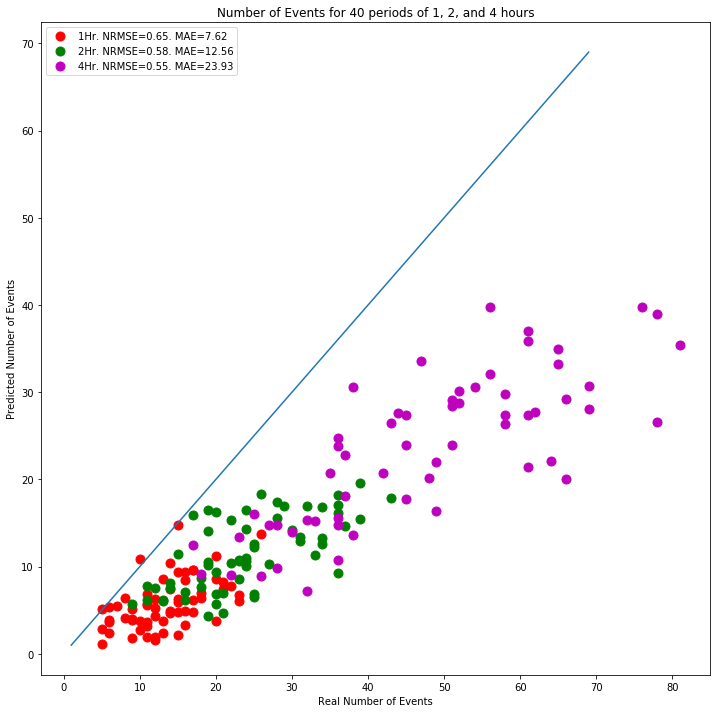

In [21]:
import sklearn.metrics
rmse1 = sqrt(sklearn.metrics.mean_squared_error(real_num_1h, pred_num_1h))/ (np.mean(real_num_1h))
rmse2 = sqrt(sklearn.metrics.mean_squared_error(real_num_2h, pred_num_2h))/(np.mean(real_num_2h))
rmse4 = sqrt(sklearn.metrics.mean_squared_error(real_num_4h, pred_num_4h))/(np.mean(real_num_4h))

mae1 = sklearn.metrics.mean_absolute_error(real_num_1h, pred_num_1h)
mae2 = sklearn.metrics.mean_absolute_error(real_num_2h, pred_num_2h)
mae4 = sklearn.metrics.mean_absolute_error(real_num_4h, pred_num_4h)

plt.figure(figsize=(12,12))
plt.plot(real_num_1h, pred_num_1h, 'r.', label = "1Hr. NRMSE="+str(round(rmse1, 2))+". MAE="+str(round(mae1, 2)), markersize=18)
plt.plot(real_num_2h, pred_num_2h, 'g.', label = "2Hr. NRMSE="+str(round(rmse2, 2))+". MAE="+str(round(mae2, 2)), markersize=18)
plt.plot(real_num_4h, pred_num_4h, 'm.', label = "4Hr. NRMSE="+str(round(rmse4, 2))+". MAE="+str(round(mae4, 2)), markersize=18)
plt.xlabel('Real Number of Events')
plt.ylabel('Predicted Number of Events')
plt.legend()
plt.title('Number of Events for 40 periods of 1, 2, and 4 hours')
x = np.arange(1, 70)
plt.plot(x, x)
#plt.plot(real_nm_24h, pred_num_24h, 'b.')


<Figure size 1440x720 with 0 Axes>

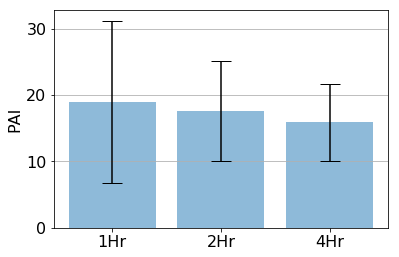

In [22]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(20,10))

labels=['1Hr',
      '2Hr', 
      '4Hr']
x_pos = np.arange(len(labels))
CTEs = [np.mean(pai_1h),
       np.mean(pai_2h), 
       np.mean(pai_4h)]

error = [np.std(pai_1h),
       np.std(pai_2h), 
       np.std(pai_4h)]

fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr = error,  alpha=0.5, ecolor='black', capsize=10)

ax.set_ylabel("PAI")
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
#ax.set_title("Average PAI for 20 predicions over 1, 2, and 4 hours \nfor 50 by 50 grid (cell size of .16 mi^2)")
ax.yaxis.grid(True)

plt.show()

#### What about peak time detection?

In [31]:
percentile = 80

In [32]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
simulation._LastTime

last_t = simulation._LastTime
indices = []
for i in range(end, len(full_data)-1):
    if (full_data.DATE_TIME[i] - last_t).total_seconds() > 3600*2: # 2 hours in seconds
        last_t = full_data.DATE_TIME[i]
        indices.append(i)
        
pred_num_2h = []
real_num_2h = []
pai_2h = []
percentile_2h = []

for i in range(0, 300):
    test_points = full_data[indices[i]:indices[i+1]]
    test_points.reset_index(drop=True, inplace=True)
    ig, ig, pred, ig, real, ig, pai = simulation.test_projection(test_points, num_hotspots=30, top_percent=0, use_simulation=False)
    pred_num_2h.append(sum(sum(pred)))
    real_num_2h.append(sum(sum(real)))
    pai_2h.append(pai)
    percentile_2h.append(np.percentile(array(pred_num_2h), percentile))
    test_points.to_csv('for_results.csv')
    simulation.update_from_new_inputs(test_points)


Predicting over time of 0.0806367547 days. Generating 8 intensity prediction(s)
Events will be projected until 0.08333333333333333 days from now

The predictive accuracy index for 30 hotspots is: 19.444444444444443. 
Hit number/Tot number: 0.16666666666666666. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 11.149769882051435

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.05155110047333883, Real: 1.0
Grid: (34, 24), Model: 0.03144671169045527, Real: 1.0
Grid: (34, 23), Model: 0.02397141952258712, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.061687653495730056, Real: 0.0
Grid: (26, 22), Model: 0.051023451003764056, Real: 0.0
Grid: (27, 22), Model: 0.04939453219013012, Real: 0.0
Grid: (27, 24), Model: 0.04716254559419021, Real: 0.0
Grid: (28, 24), Model: 0.037005551957824206, Real: 0.0
Grid: (26, 23), Model: 0.034307771750404344, Real: 0.0
Grid: (37, 23), Model: 0.0337033115952074, Real: 0.0
Grid: (27, 31), Model: 0.

/home/march/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value



The predictive accuracy index for 30 hotspots is: 10.144927536231883. 
Hit number/Tot number: 0.08695652173913043. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 13.890922842191024

Predicted hotspots in real top 30
Grid: (33, 1), Model: 0.03465824639640724, Real: 1.0
Grid: (34, 23), Model: 0.03195568396589026, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.07627305736729215, Real: 0.0
Grid: (28, 23), Model: 0.06564282200195025, Real: 0.0
Grid: (26, 22), Model: 0.06318247536680903, Real: 0.0
Grid: (27, 22), Model: 0.061142842769934806, Real: 0.0
Grid: (27, 24), Model: 0.058475046631675, Real: 0.0
Grid: (28, 24), Model: 0.0456351522420503, Real: 0.0
Grid: (26, 23), Model: 0.042431783443430134, Real: 0.0
Grid: (37, 23), Model: 0.04158835448894381, Real: 0.0
Grid: (34, 24), Model: 0.04118292925117582, Real: 0.0
Grid: (27, 31), Model: 0.04109667037170575, Real: 0.0
Grid: (32, 25), Model: 0.039147382809995995, Real: 0.0
Grid: (51, 33


The predictive accuracy index for 30 hotspots is: 23.333333333333332. 
Hit number/Tot number: 0.2. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 21.31488596236129

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.11804376352100411, Real: 1.0
Grid: (33, 1), Model: 0.055169469656533736, Real: 2.0
Grid: (36, 23), Model: 0.04447307090206201, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (26, 22), Model: 0.1017262195488203, Real: 0.0
Grid: (28, 23), Model: 0.09739113181896909, Real: 0.0
Grid: (27, 22), Model: 0.09210432319389052, Real: 0.0
Grid: (27, 24), Model: 0.09163281352244175, Real: 0.0
Grid: (28, 24), Model: 0.06811144409649404, Real: 0.0
Grid: (37, 23), Model: 0.0654958083884391, Real: 0.0
Grid: (34, 24), Model: 0.06506607801817703, Real: 0.0
Grid: (26, 23), Model: 0.0637743103981684, Real: 0.0
Grid: (27, 31), Model: 0.061954079201774634, Real: 0.0
Grid: (32, 25), Model: 0.05895509785203687, Real: 0.0
Grid: (35, 32), Model: 0.056414


The predictive accuracy index for 30 hotspots is: 13.565891472868216. 
Hit number/Tot number: 0.11627906976744186. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 24.03554809307006

Predicted hotspots in real top 30
Grid: (27, 23), Model: 0.13687855522923711, Real: 2.0
Grid: (27, 24), Model: 0.10488964864492827, Real: 1.0
Grid: (33, 1), Model: 0.07484289511063824, Real: 1.0
Grid: (37, 24), Model: 0.053018422470038545, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (28, 23), Model: 0.11380130323844193, Real: 0.0
Grid: (26, 22), Model: 0.11143686865281381, Real: 0.0
Grid: (27, 22), Model: 0.10526492523815503, Real: 0.0
Grid: (28, 24), Model: 0.07460946866943174, Real: 0.0
Grid: (37, 23), Model: 0.07153020969070634, Real: 0.0
Grid: (34, 24), Model: 0.07124438837535876, Real: 0.0
Grid: (26, 23), Model: 0.07024857354094236, Real: 0.0
Grid: (27, 31), Model: 0.06843082325694443, Real: 0.0
Grid: (32, 25), Model: 0.06506354746585029, Real: 0.0
Grid: (35, 32


The predictive accuracy index for 30 hotspots is: 12.280701754385964. 
Hit number/Tot number: 0.10526315789473684. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 14.110044505435354

Predicted hotspots in real top 30
Grid: (51, 33), Model: 0.03469847034412611, Real: 1.0
Grid: (29, 22), Model: 0.030986805541848086, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.08645348080246609, Real: 0.0
Grid: (28, 23), Model: 0.0687654740817795, Real: 0.0
Grid: (27, 24), Model: 0.06650478995277095, Real: 0.0
Grid: (26, 22), Model: 0.06372495835383161, Real: 0.0
Grid: (27, 22), Model: 0.06034852733987969, Real: 0.0
Grid: (33, 1), Model: 0.04414674650275856, Real: 0.0
Grid: (34, 24), Model: 0.042910253887741806, Real: 0.0
Grid: (28, 24), Model: 0.0426362192078912, Real: 0.0
Grid: (37, 23), Model: 0.0407851449602394, Real: 0.0
Grid: (26, 23), Model: 0.040318863973360194, Real: 0.0
Grid: (27, 31), Model: 0.03937211823803398, Real: 0.0
Grid: (32, 25


The predictive accuracy index for 30 hotspots is: 25.925925925925924. 
Hit number/Tot number: 0.2222222222222222. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 7.679303632053785

Predicted hotspots in real top 30
Grid: (29, 22), Model: 0.01783686655310542, Real: 1.0
Grid: (33, 25), Model: 0.017197664666144828, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.04569090908811071, Real: 0.0
Grid: (28, 23), Model: 0.037423968040216846, Real: 0.0
Grid: (27, 24), Model: 0.03652965196969737, Real: 0.0
Grid: (26, 22), Model: 0.03407927270694883, Real: 0.0
Grid: (27, 22), Model: 0.03235098750355705, Real: 0.0
Grid: (33, 1), Model: 0.023174582747802156, Real: 0.0
Grid: (34, 24), Model: 0.022826648247660498, Real: 0.0
Grid: (28, 24), Model: 0.022784975832971958, Real: 0.0
Grid: (26, 23), Model: 0.022776441767892317, Real: 0.0
Grid: (32, 25), Model: 0.022448757176970376, Real: 0.0
Grid: (27, 31), Model: 0.022314124866422366, Real: 0.0
Grid: (


The predictive accuracy index for 30 hotspots is: 27.999999999999996. 
Hit number/Tot number: 0.24. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 17.168418717421932

Predicted hotspots in real top 30
Grid: (27, 22), Model: 0.07143445983512552, Real: 1.0
Grid: (32, 25), Model: 0.049168634683099, Real: 1.0
Grid: (27, 31), Model: 0.049158137608024746, Real: 1.0
Grid: (26, 27), Model: 0.03878650214592748, Real: 1.0
Grid: (47, 32), Model: 0.03689419188105417, Real: 1.0
Grid: (28, 19), Model: 0.034948477742467426, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.09975317942777288, Real: 0.0
Grid: (28, 23), Model: 0.08121770152603944, Real: 0.0
Grid: (26, 22), Model: 0.08022052551834316, Real: 0.0
Grid: (27, 24), Model: 0.079827437094107, Real: 0.0
Grid: (33, 1), Model: 0.050316058939005315, Real: 0.0
Grid: (28, 24), Model: 0.05017891857236609, Real: 0.0
Grid: (34, 24), Model: 0.05010814622153585, Real: 0.0
Grid: (26, 23), Model: 0.0500


The predictive accuracy index for 30 hotspots is: 17.94871794871795. 
Hit number/Tot number: 0.15384615384615385. Hit area/Tot area: 0.008571428571428572

The predicted number of events is: 27.471918661223683

Predicted hotspots in real top 30
Grid: (28, 23), Model: 0.13017163891434153, Real: 3.0
Grid: (27, 24), Model: 0.1286037885031707, Real: 1.0
Grid: (26, 27), Model: 0.06475661107851755, Real: 1.0
Grid: (33, 25), Model: 0.06321186039637161, Real: 1.0

Predicted hotstpots not in real top 30
Grid: (27, 23), Model: 0.15530894646096974, Real: 0.0
Grid: (26, 22), Model: 0.12940219256586852, Real: 0.0
Grid: (27, 22), Model: 0.12056079808962893, Real: 0.0
Grid: (32, 25), Model: 0.0852401901594383, Real: 0.0
Grid: (27, 31), Model: 0.08103511268361753, Real: 0.0
Grid: (28, 24), Model: 0.07866300507449357, Real: 0.0
Grid: (26, 23), Model: 0.07837914173673592, Real: 0.0
Grid: (34, 24), Model: 0.07837506187962126, Real: 0.0
Grid: (33, 1), Model: 0.07798226706365019, Real: 0.0
Grid: (37, 23), 

KeyboardInterrupt: 

In [ ]:
pred_num_2h = array(pred_num_2h)
real_num_2h = array(real_num_2h)
percentile_2h = array(percentile_2h)
np.mean(percentile_2h), np.percentile(pred_num_2h, percentile), np.percentile(real_num_2h, percentile)

In [ ]:
import sklearn.metrics
rmse2 = sqrt(sklearn.metrics.mean_squared_error(real_num_2h, pred_num_2h))/(np.mean(real_num_2h))

mae2 = sklearn.metrics.mean_absolute_error(real_num_2h, pred_num_2h)

plt.figure(figsize=(12,12))
plt.plot(real_num_2h, pred_num_2h, 'g.', label = "2Hr. NRMSE="+str(round(rmse2, 2))+". MAE="+str(round(mae2, 2)), markersize=18)
plt.xlabel('Real Number of Events')
plt.ylabel('Predicted Number of Events')
plt.legend()
plt.title('Number of Events for 200 periods of 2 hours')
x = np.arange(1, 60)
plt.plot(x, x)

In [ ]:
st_indx = 100
pred = pred_num_2h[st_indx:] - percentile_2h[st_indx:]
neg_indx = pred < 0
pred[neg_indx] = 0
pos_indx = pred > 0
pred[pos_indx] = 1


real = real_num_2h[st_indx:] - np.percentile(real_num_2h, percentile)
neg_indx = real < 0
real[neg_indx] = 0
pos_indx = real > 0
real[pos_indx] = 1

In [ ]:
import sklearn.metrics

sklearn.metrics.roc_auc_score(pred, real)

In [ ]:
num_events_in_top_percentile = 0
false_neg = 0
true_neg = 0
false_pos = 0
true_pos = 0

for i in range(0, len(real)):
    if real[i]:
        num_events_in_top_percentile += 1
    if real[i] and pred[i]:
        true_pos += 1
    elif real[i] and not pred[i]:
        false_neg += 1
    elif not real[i] and not pred[i]:
        true_neg +=1
    elif not real[i] and pred[i]:
        false_pos +=1
print("\nTot num top percentile events: ")
print(num_events_in_top_percentile)
print('\nTrue pos: ')
print(true_pos)
print("\nFalse neg: ")
print(false_neg)
print("\nFalse pos: ")
print(false_pos)
print("\nTrue neg: ")
print(true_neg)

### Checking Wasserstein

In [33]:
simulation = PointProcessRun(param_location = save_loc, save_loc = 'PPtesting.npz')
start_time = simulation._LastTime
num = 300
future_intensity, times, incr = simulation.get_future_events(start_time, num, 0)
future_intensity = sum(future_intensity)
wasserstein_locs = simulation.locs_for_wasserstein(start_time, num, top_percent=96)


TypeError: get_future_events() missing 1 required positional argument: 'top_percent'

In [ ]:
wasserstein_locs

In [ ]:
cluster = Cluster(wasserstein_locs, n = 6)
cluster.randomize_centers()
lam = cluster.learn_lam(n_iter=8, rand_centers=False)
centers= cluster.get_centers()
centers_grid_x = np.zeros(len(centers))
centers_grid_y = np.zeros(len(centers))

for i in range(0, len(centers)):
    x, y = simulation.coord_to_grid(centers[i][1], centers[i][0])
    centers_grid_x[i] = x
    centers_grid_y[i] = y
centers_grid_x, centers_grid_y

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(np.transpose(future_intensity),cmap='hot', interpolation = 'nearest')
plt.title('Future predictions over 4 hours')
plt.plot(centers_grid_x, centers_grid_y, 'g.', markersize = 20)
plt.colorbar()
plt.show()